In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import torch
import random
import os

from utils import normalize
from torch.utils.data import DataLoader

from mod_moving_mnist import ModMovingMNISTDataset
from mpnnlstm import NextFramePredictorS2S
from model import MPNNLSTM, MPNNLSTMI

/Users/zach/opt/miniconda3/envs/thesis/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/zach/opt/miniconda3/envs/thesis/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [81]:
np.random.seed(1)
random.seed(1)
torch.manual_seed(1)

def collate_fn(batch):
    return batch[0]

input_features = 1
input_timesteps = 4
output_timesteps = 10

# Create a dataset using the modified MovingMNIST
mnist_kwargs = dict(
    input_timesteps=input_timesteps,
    output_timesteps=output_timesteps,
    n_digits=1,
    gap=0,
    canvas_size=(32, 32),
    digit_size=(18, 18),
    pixel_noise=0.05,
    velocity_noise=0.0#1  # 0.15
)

# Create a train set (500), test set (50), and validation set (50)
data_train = ModMovingMNISTDataset(100, **mnist_kwargs)
data_test = ModMovingMNISTDataset(50, **mnist_kwargs)
data_val = ModMovingMNISTDataset(50, **mnist_kwargs)

loader_train = DataLoader(data_train, batch_size=1, shuffle=True)
loader_test = DataLoader(data_test, batch_size=1, shuffle=True)
loader_val = DataLoader(data_val, batch_size=1, shuffle=False)

In [87]:
from mpnnlstm import NextFramePredictor

from torch.optim.lr_scheduler import StepLR
import time
import pandas as pd
from tqdm import tqdm

from graph_functions import image_to_graph, flatten, create_graph_structure, unflatten
from utils import add_positional_encoding

np.random.seed(1)
random.seed(1)
torch.manual_seed(1)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device('mps')

# Add 3 to the number of input features since we add positional encoding (x, y) and node size (s)
model_kwargs = dict(
    hidden_size=32,
    dropout=0.1,
    n_layers=2
)


model = NextFramePredictorS2S(
    thresh=0.1,
    experiment_name='test',
    decompose=True,
    input_features=1,
    device=device,
    output_timesteps=output_timesteps,
    model_kwargs=model_kwargs)

model.get_n_params()

28929

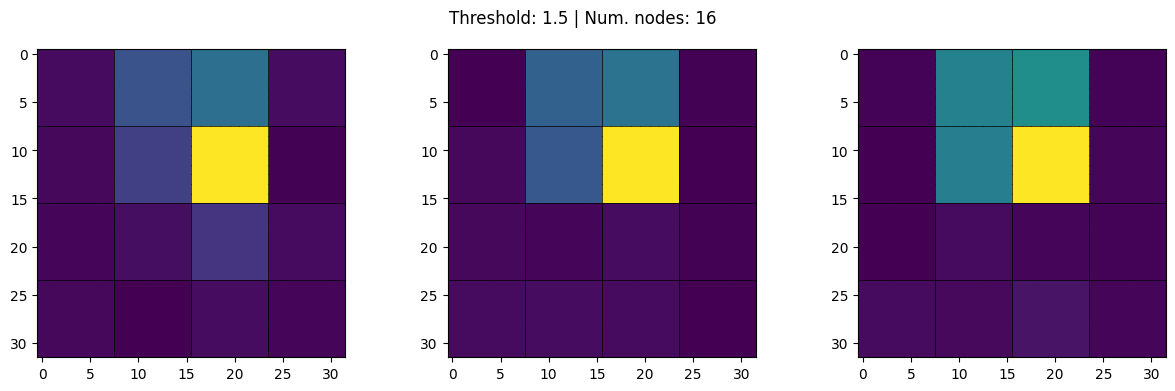

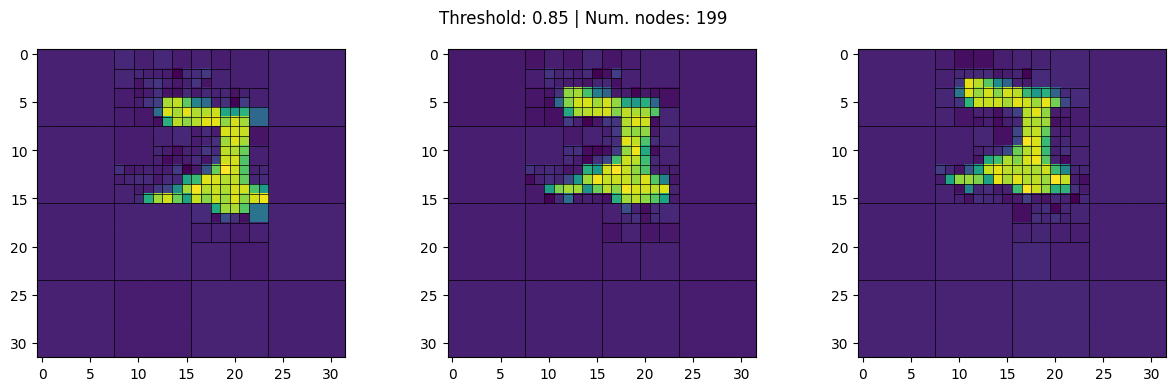

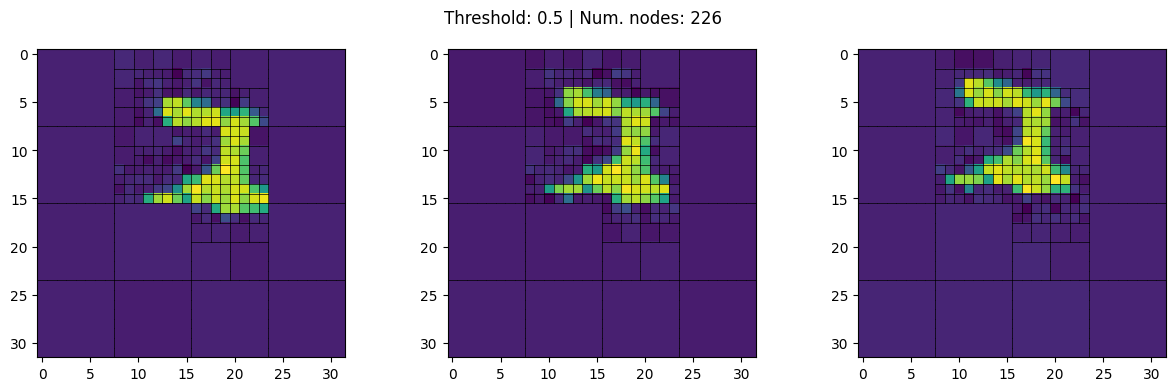

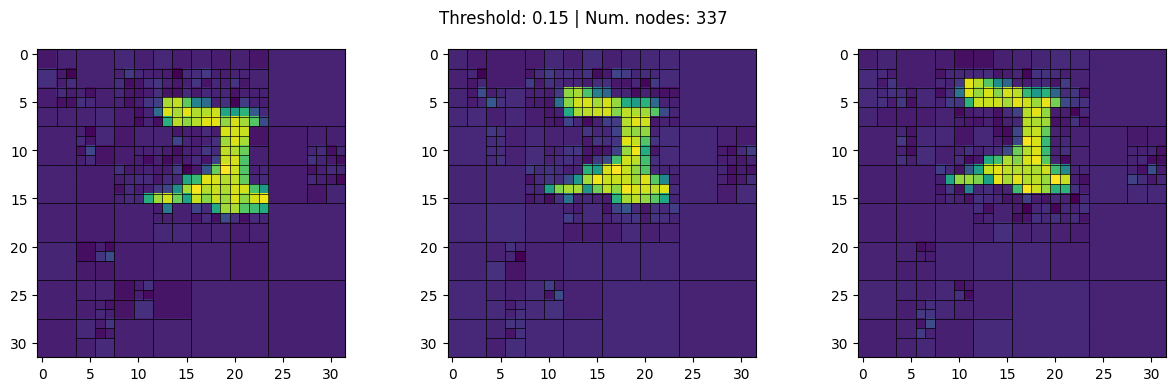

In [5]:
x, _ = next(iter(loader_val))
x = x.squeeze(0)

fig, axs = model.test_threshold(x, thresh=1.5)
plt.show()

fig, axs = model.test_threshold(x, thresh=0.85)
plt.show()

fig, axs = model.test_threshold(x, thresh=0.5)
plt.show()

fig, axs = model.test_threshold(x, thresh=0.15)
plt.show()

In [ ]:
model.train(loader_train, loader_test, lr=0.01, n_epochs=20)

100%|███████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.85it/s]


Epoch 0 train MSE: 0.3049, test MSE: 0.2891, lr: 0.0100, time_per_epoch: 34.7


100%|███████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.32it/s]


Epoch 1 train MSE: 0.2854, test MSE: 0.2779, lr: 0.0100, time_per_epoch: 36.1


100%|███████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.08it/s]


Epoch 2 train MSE: 0.2813, test MSE: 0.2711, lr: 0.0095, time_per_epoch: 36.7


100%|███████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.22it/s]


Epoch 3 train MSE: 0.2758, test MSE: 0.2685, lr: 0.0095, time_per_epoch: 36.8


100%|███████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.28it/s]


Epoch 4 train MSE: 0.2734, test MSE: 0.2642, lr: 0.0095, time_per_epoch: 36.8


100%|███████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.96it/s]


Epoch 5 train MSE: 0.2640, test MSE: 0.2656, lr: 0.0090, time_per_epoch: 37.2


100%|███████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.64it/s]


Epoch 6 train MSE: 0.2648, test MSE: 0.2642, lr: 0.0090, time_per_epoch: 37.3


100%|███████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.13it/s]


Epoch 7 train MSE: 0.2557, test MSE: 0.2582, lr: 0.0090, time_per_epoch: 37.8


100%|███████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.11it/s]


Epoch 8 train MSE: 0.2516, test MSE: 0.2533, lr: 0.0086, time_per_epoch: 38.8


100%|███████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:11<00:00,  4.45it/s]


Epoch 9 train MSE: 0.2464, test MSE: 0.2443, lr: 0.0086, time_per_epoch: 39.7


100%|███████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.15it/s]


Epoch 10 train MSE: 0.2414, test MSE: 0.2489, lr: 0.0086, time_per_epoch: 40.3


 98%|█████████████████████████████████████████████████████████████████████████████████████████▏ | 49/50 [00:08<00:00,  5.61it/s]

<Axes: >

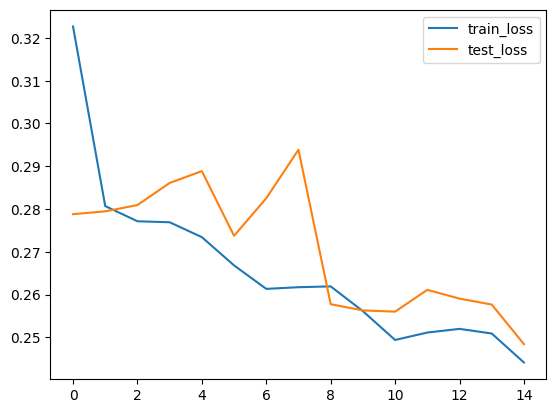

In [75]:
model.loss.plot()

In [78]:
y_hat = model.predict(loader_val)

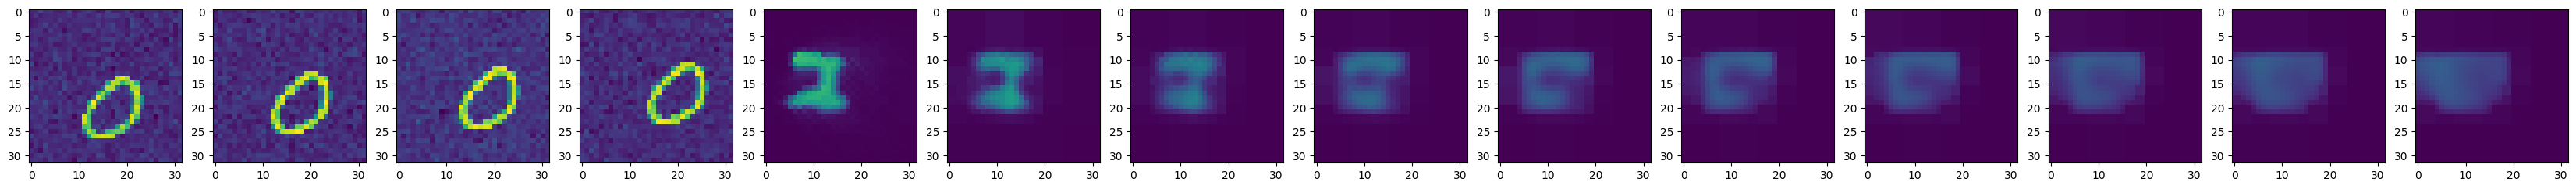

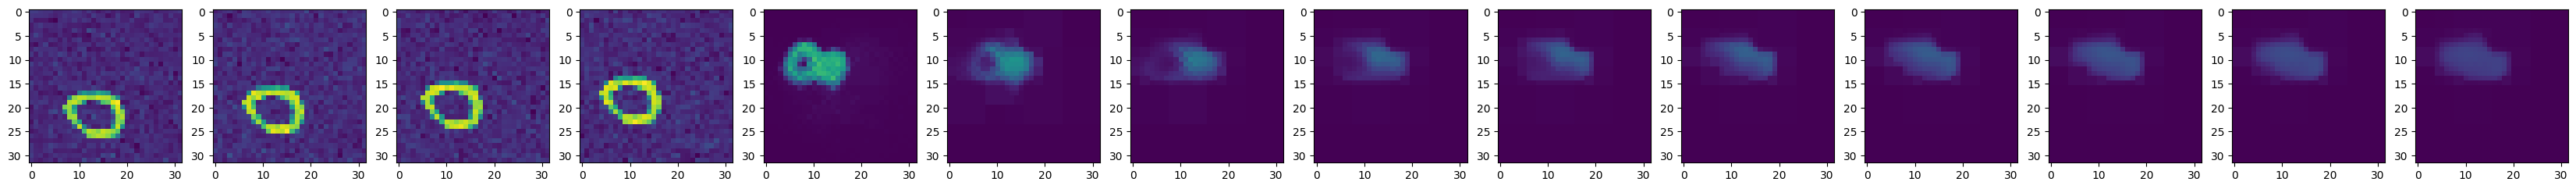

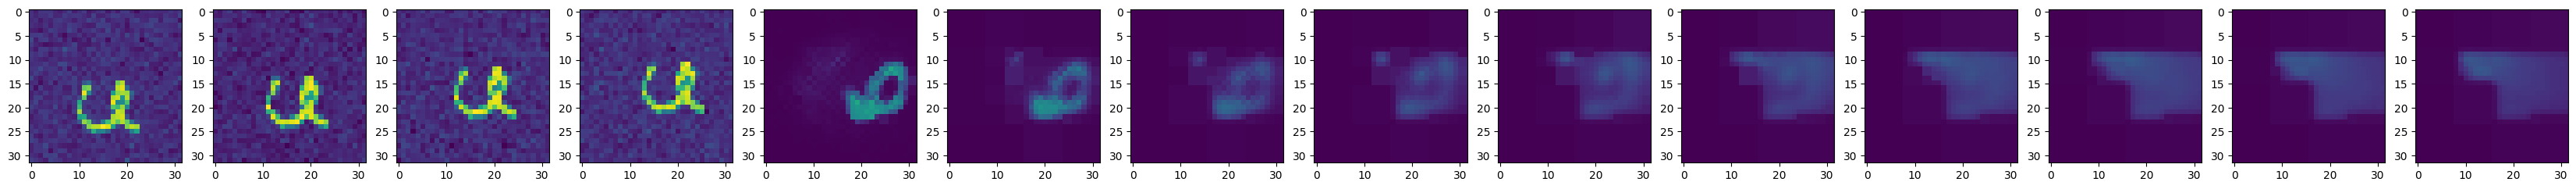

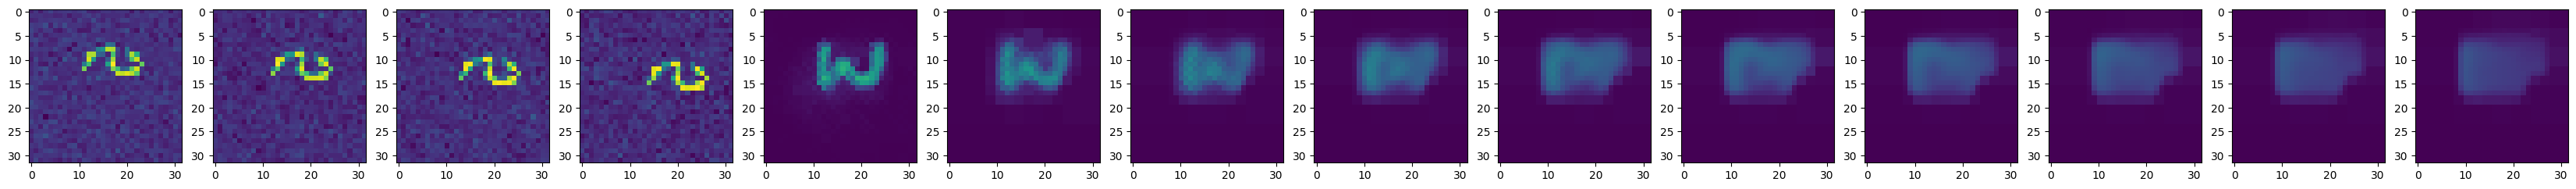

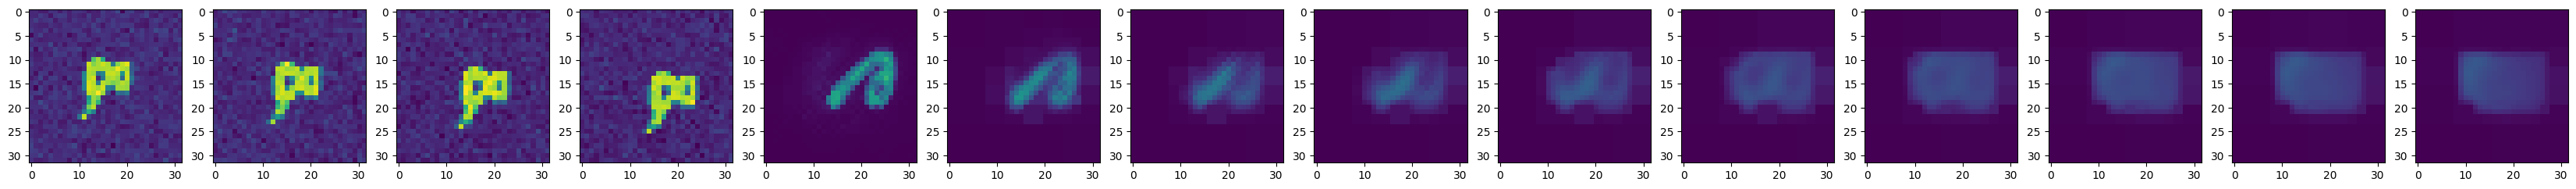

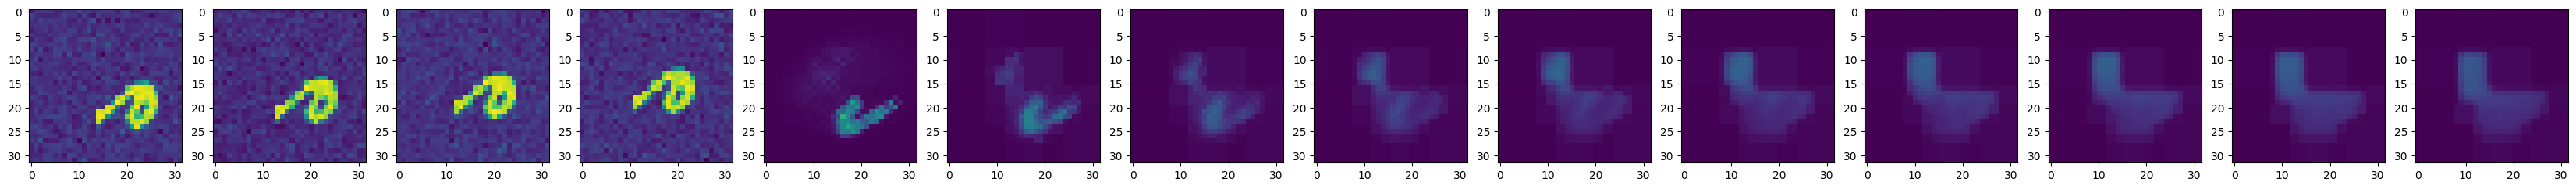

In [79]:
# Plot some example 
num_frames = 6

for i in range(num_frames):
    fig, axs = plt.subplots(1, input_timesteps+output_timesteps, figsize=(3*(input_timesteps+output_timesteps), 4))
    
    # Inputs
    for j in range(input_timesteps):
        axs[j].imshow(loader_test.dataset.x[i][j, ..., 0])
    
    for j in range(output_timesteps):
        axs[input_timesteps+j].imshow(y_hat[i][j][..., 0], vmin=0, vmax=1)  # Prediction

In [ ]:
model.loss.iloc[1:].plot()